In [1]:
import tensorflow as tf
import math

In [2]:
# datasetPath = "/nfs/general/shared/pos/*/*.jpg"
# if not os.path.exists('/nfs/general/shared/pos/'):
#   path_to_downloaded_file = tf.keras.utils.get_file(
#     'position_training_data',
#     'https://github.com/geligeli/rpi_color_detector/raw/master/data.tar.gz',
#     untar=True)
#   datasetPath = os.path.dirname(path_to_downloaded_file) + "/nfs/general/shared/pos/*/*.jpg"

# all_dataset = tf.data.Dataset.list_files(datasetPath).shuffle(buffer_size=10000).cache()

# data_augmentation = tf.keras.Sequential(
#     [
# #        tf.keras.layers.RandomRotation(0.1),
#         tf.keras.layers.RandomTranslation(0.1,0.1)
#     ]
# )

datasetPath = "/nfs/general/shared/pos/*/*.jpg"

all_dataset = tf.data.Dataset.list_files(datasetPath).shuffle(buffer_size=10000)


def CreateImageAndLabel(filename):
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image.set_shape([480, 640, 3])
    subdir = int(tf.strings.split(filename,'/')[5])
    radians = float(subdir % 80) / 80.0 * 2.0 * math.pi
    return image, [tf.sin(radians), tf.cos(radians)]


@tf.function(input_signature=[tf.TensorSpec(shape=(None, 480, 640, 3), dtype=tf.float32)])
def ExtractRoiForPrediction(image):
    #return tf.image.convert_image_dtype(tf.image.crop_to_bounding_box(image, 220, 260, 40, 80), tf.float32)
    return tf.image.rgb_to_grayscale(tf.image.crop_to_bounding_box(image, 220,70,100,500))


data_augmentation = tf.keras.Sequential(
    [
        # tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomTranslation(0.1,0.1)
    ]
)


AUTOTUNE = tf.data.AUTOTUNE

test_dataset = all_dataset.take(1000)
test_dataset = test_dataset.map(CreateImageAndLabel, num_parallel_calls=AUTOTUNE,deterministic=False)
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE, deterministic=False)
test_dataset = test_dataset.map(lambda x, y: (ExtractRoiForPrediction(x), y), num_parallel_calls=AUTOTUNE, deterministic=False)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

train_dataset = all_dataset.skip(1000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.map(CreateImageAndLabel, num_parallel_calls=AUTOTUNE,deterministic=False)
train_dataset = train_dataset.batch(16)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE, deterministic=False)
train_dataset = train_dataset.map(lambda x, y: (ExtractRoiForPrediction(x), y), num_parallel_calls=AUTOTUNE, deterministic=False)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (5, 5), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(8, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(8, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    decay_rate=0.9,
    staircase=True)


checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),  # 'adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mean_absolute_error'])

tb_callback = tf.keras.callbacks.TensorBoard('/tmp/logs', update_freq=1)

model.fit(train_dataset, epochs=200, steps_per_epoch=256,
          validation_data=test_dataset, callbacks=[tb_callback, model_checkpoint_callback])



In [ ]:
tf.saved_model.save(model, '/nfs/general/shared/tf_models/orientation')
converter = tf.lite.TFLiteConverter.from_saved_model('/nfs/general/shared/tf_models/orientation') # path to the SavedModel directory
tflite_model = converter.convert()
open('/nfs/general/shared/tflite/orientation.tflite', 'wb').write(tflite_model)


INFO:tensorflow:Assets written to: /nfs/general/shared/tf_models/orientation/assets


INFO:tensorflow:Assets written to: /nfs/general/shared/tf_models/orientation/assets
2022-04-19 20:59:07.743820: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-19 20:59:07.743838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-19 20:59:07.743964: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /nfs/general/shared/tf_models/orientation
2022-04-19 20:59:07.745976: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-19 20:59:07.745987: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /nfs/general/shared/tf_models/orientation
2022-04-19 20:59:07.748952: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-19 20:59:07.787615: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /nfs/general/shared/tf_

390232

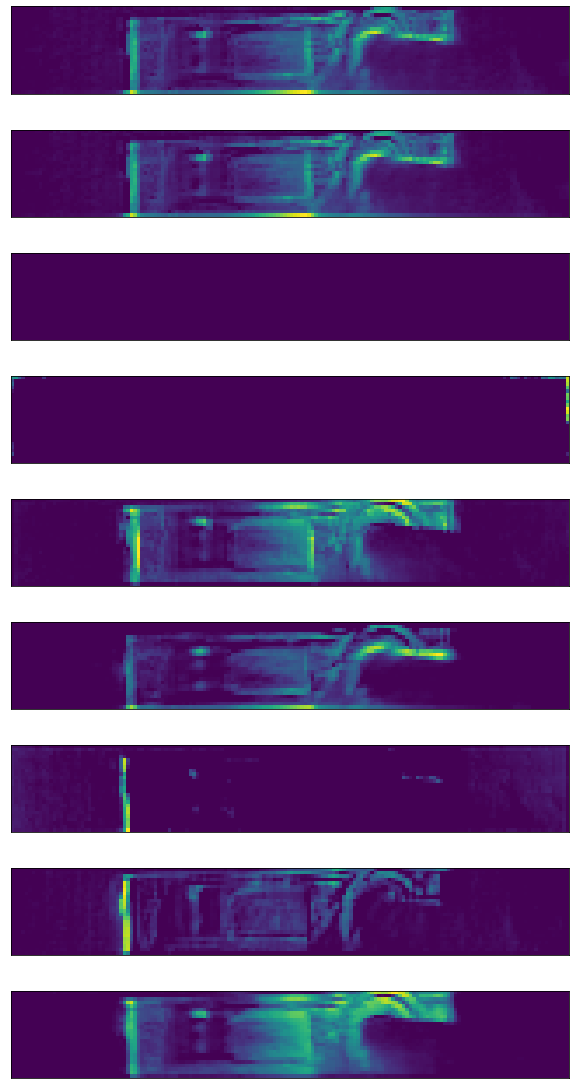

In [ ]:
sample=test_dataset.take(1)
sample=next(iter(sample))
sample=sample[0]
#print(model.layers[:4])
for l in model.layers[:4]:
    sample = l(sample)

# f1=l.apply(sample[0])
plt.rcParams['figure.figsize'] = [10, 20]
numFilters=l.output_shape[-1]
numImages=numFilters+1

ax = plt.subplot(numImages, 1,1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(sample[0,:,:,0])
for j in range(numImages-1):
    ax = plt.subplot(numImages, 1,j+2)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample[0,:,:,j].numpy())
# w=model.layers[0].get_weights()

# from matplotlib import pyplot as plt
# plt.imshow(w[0][:,:,0,4])

8

In [ ]:
# from sklearn.decomposition import PCA
# foo=PCA(n_components=5).fit_transform(tf.concat((a_quantized,b_quantized),axis=0).numpy())
# plt.scatter(foo[:,0],foo[:,1],color='r')

# plt.scatter(foo[:a_quantized.shape[0],0],foo[:a_quantized.shape[0],1],color='g')

m = Quantizer()
a_quantized=tf.vectorized_map(m.QuantizeHist, aside)
b_quantized=tf.vectorized_map(m.QuantizeHist, bside)


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

X=tf.concat((a_quantized,b_quantized),axis=0)

y=tf.concat((tf.zeros((a_quantized.shape[0],)),tf.ones((b_quantized.shape[0],))),axis=0)
model.fit(X, y, epochs=5000)
# fashion_mnist = tf.keras.datasets.fashion_mnist

# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])



# 


Epoch 1/5000
63/63 [==============================] - 0s 533us/step - loss: 46.1805 - accuracy: 0.8629
Epoch 2/5000
63/63 [==============================] - 0s 637us/step - loss: 0.7853 - accuracy: 0.9955
Epoch 3/5000
63/63 [==============================] - 0s 668us/step - loss: 0.7259 - accuracy: 0.9965
Epoch 4/5000
63/63 [==============================] - 0s 709us/step - loss: 0.6237 - accuracy: 0.9960
Epoch 5/5000
63/63 [==============================] - 0s 725us/step - loss: 0.6276 - accuracy: 0.9945
Epoch 6/5000
63/63 [==============================] - 0s 641us/step - loss: 0.5707 - accuracy: 0.9955
Epoch 7/5000
63/63 [==============================] - 0s 644us/step - loss: 0.4273 - accuracy: 0.9970
Epoch 8/5000
63/63 [==============================] - 0s 714us/step - loss: 0.5585 - accuracy: 0.9945
Epoch 9/5000
63/63 [==============================] - 0s 663us/step - loss: 0.3866 - accuracy: 0.9980
Epoch 10/5000
63/63 [==============================] - 0s 619us/step - loss: 0.37

In [ ]:
class ImageClassifier(tf.Module):
    def __init__(self):
      self.classifier = probability_model
      self.quantizer = Quantizer()
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[480, 640, 3], dtype=tf.uint8)])
    def Classify(self, sample_image):
      #return probability_model(tf.expand_dims(self.quantizer.QuantizeHist(sample_image), 0))
      return self.classifier(tf.expand_dims(self.quantizer.QuantizeHist(sample_image),0))


model = ImageClassifier()

tf.saved_model.save(model, '/tmp/classifier')
converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/classifier') # path to the SavedModel directory
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
#   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
open('/nfs/general/shared/adder.tflite', 'wb').write(tflite_model)


# model_spec.IMAGE_CLASSIFICATION_MODELS
# spec=model_spec.get('efficientnet_lite4')

# spec.input_image_shape

2022-04-18 06:17:21.645663: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/classifier/assets
Estimated count of arithmetic ops: 3.712 M  ops, equivalently 1.856 M  MACs


2022-04-18 06:17:22.271461: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-18 06:17:22.271481: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-18 06:17:22.272020: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/classifier
2022-04-18 06:17:22.273158: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-18 06:17:22.273166: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/classifier
2022-04-18 06:17:22.276387: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-18 06:17:22.300056: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/classifier
2022-04-18 06:17:22.314528: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 42509 micr

9336

In [ ]:
model.Classify(aside[10,:,:,:])

# validation_data, test_data = rest_data.split(0.5)
# model = image_classifier.create(train_data, model_spec=model_spec.get('efficientnet_lite4'), validation_data=validation_data, epochs = 20)


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>

In [ ]:
class Adder(tf.Module):
  @tf.function(input_signature=[tf.TensorSpec(shape=[480,640], dtype=tf.uint8)])
  def add(self, image):
    image = image[tf.newaxis, ..., tf.newaxis]
    return image

model = Adder()
tf.saved_model.save(model, '/tmp/adder')


converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/adder') # path to the SavedModel directory
tflite_model = converter.convert()

with open('/nfs/general/shared/adder.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/adder/assets


INFO:tensorflow:Assets written to: /tmp/adder/assets
2022-04-16 15:17:41.245018: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-16 15:17:41.245037: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


Estimated count of arithmetic ops: 0  ops, equivalently 0  MACs


2022-04-16 15:17:41.245221: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/adder
2022-04-16 15:17:41.245395: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-16 15:17:41.245403: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/adder
2022-04-16 15:17:41.245820: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-16 15:17:41.254473: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/adder
2022-04-16 15:17:41.257203: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 11982 microseconds.
2022-04-16 15:17:41.268568: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1963] Estimated count of arithmetic ops: 0  ops, equivalently 0  MACs



In [10]:
class Foo():
    def __init__(self):
        self.cgi_methods = {method: self.__getattribute__(method) for method in dir(type(self)) if method.startswith('CGI_')}
    def CGI_doEx(self):
        return 123
    def CGI_doEx2(self):
        return 443
    def aasdf(self):
        return 443

f=Foo()

In [12]:
f.cgi_methods['CGI_doEx']()


123

['CGI_doEx', 'CGI_doEx2']